In [25]:
%pip install qiskit
%pip install qiskit-ibmq-provider

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
from qiskit import IBMQ

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate, ClassicalRegister
from qiskit import transpile, schedule
from qiskit.pulse import Schedule, Play, ControlChannel, GaussianSquare
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [27]:
IBMQ.save_account('37e705156a95d8ed24c79515ed1bf2bd894cf85c45cfd22298a079e23f6a2d7ae2a22555ebfdb8e99d7daa4b998a4280fbae7f6c0e6fe97b832e3cd0c8a1a0ef', overwrite=True)
IBMQ.load_account()

# get backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_osaka')
backend_defaults = backend.defaults()

ibmqfactory.load_account:WARNING:2024-05-04 12:49:39,096: Credentials are already in use. The existing account in the session will be replaced.


In [28]:
qubit_frequency_data = []
qubit_pi_pulse_data = []
qubit_classifiers = []

In [29]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

backend_properties = backend.properties()
control_qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[control_qubit] # Default qubit frequency in Hz.
print(f"Qubit {control_qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[control_qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 4.822496763471751 GHz.
Default anharmonicity is -0.30896613792557315 GHz.


In [30]:
def get_job_data(job, average, qubit):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

Finding |1> to |2> Transition Frequency

In [31]:
x12_duration = 160
x12_sigma = 40
num_freqs = 75
drive_power = 0.15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

In [32]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(control_qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [33]:
basis_gates = backend.configuration().basis_gates

basis_gates += ["spect"]
# print(basis_gates)
inst_map = backend_defaults.instruction_schedule_map
inst_map.add("spect", [control_qubit], schedule)

spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(control_qubit+1, control_qubit+1)

qc_spect.x(control_qubit)
qc_spect.append(spect_gate, [control_qubit])
qc_spect.measure(control_qubit, control_qubit)
qc_spect.add_calibration(spect_gate, (control_qubit,), freq12_sweep_sched, [freq])


exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

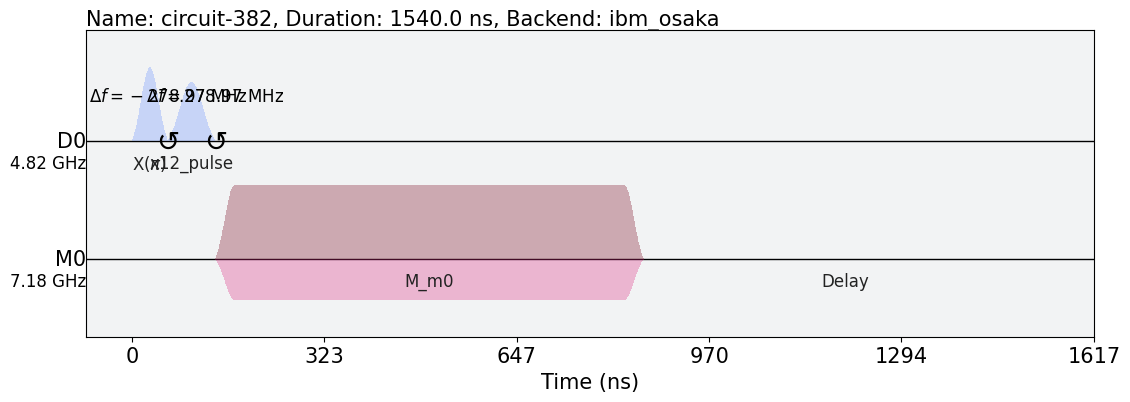

In [34]:
from qiskit import transpile, schedule

schedule = schedule(exp_spect_circs[-1], backend)
schedule.draw(backend=backend)

In [35]:
# excited_freq_sweep_job = backend.run(exp_spect_circs,
#                                      meas_level=1,
#                                      meas_return='avg',
#                                      shots=2048)

In [36]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit, conv

In [37]:
# excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_freq_sweep_data = get_job_data(backend.retrieve_job('crv2wehgd8qg008rnwqg'), average=True, qubit = control_qubit)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

In [40]:
(excited_sweep_fit_params,
 excited_sweep_y_fit, err) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data,
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.515*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

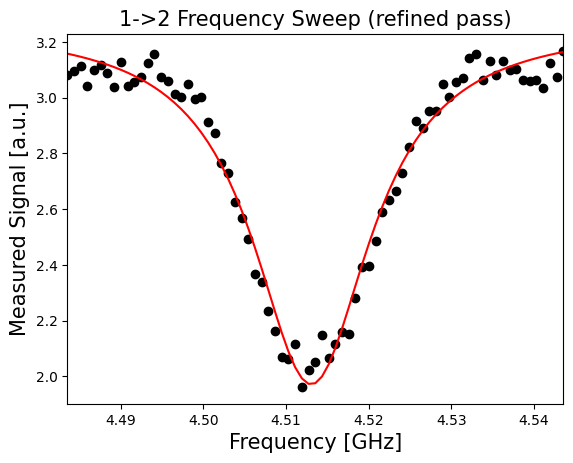

In [41]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [42]:
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} +/- {np.sqrt(err[1,1]/GHz**2)} GHz.")
print("The transition frequency from |1> to |2> is  %.4f +/- %.3e" %(excited_sweep_fit_params[1]/GHz, np.sqrt(err[1,1]/GHz**2)))

Our updated estimate for the 1->2 transition frequency is 4.513041 +/- 0.00014846898741164327 GHz.
The transition frequency from |1> to |2> is  4.5130 +/- 1.485e-04


In [43]:
qubit_frequency_data.append(qubit_12_freq)

Rabi Experiment for |1>->|2>

In [44]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [45]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(control_qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [46]:
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.x(0)
qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

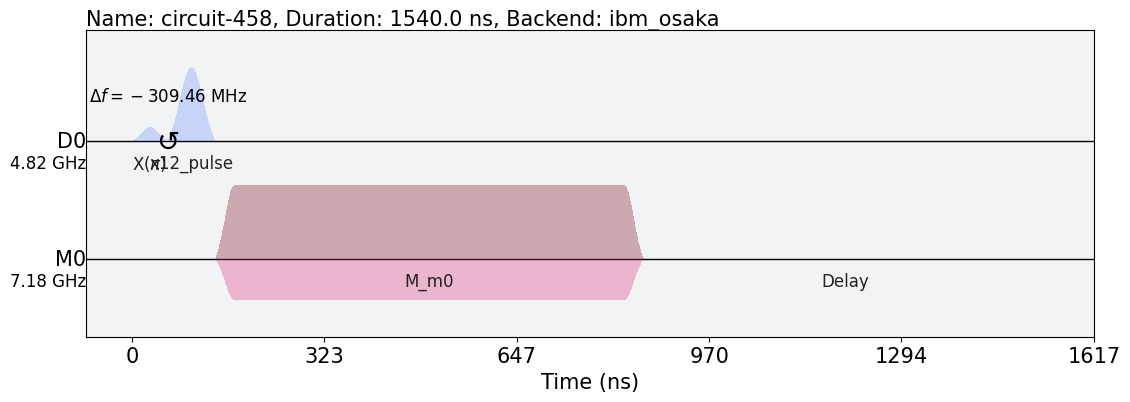

In [47]:
from qiskit import transpile, schedule

schedule = schedule(exp_rabi_circs[-1], backend)
schedule.draw(backend=backend)

In [48]:
# rabi_12_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=2048)

In [62]:
rabi_12_data = get_job_data(backend.retrieve_job('crv6f2w7wv80008fdke0'), average=True, qubit = 0)

In [65]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

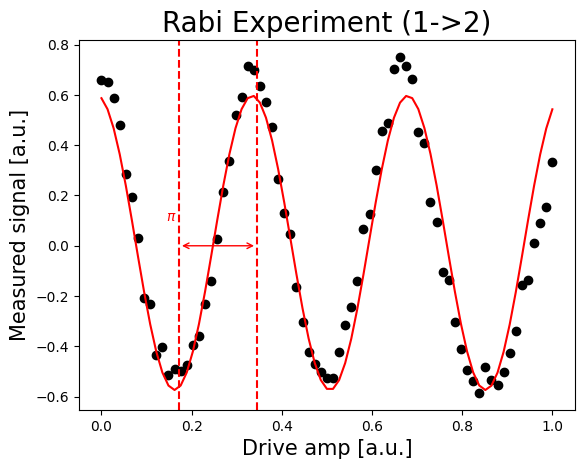

In [67]:
# Note: Only real part of data is plotted
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit, err) = fit_function(drive_amps,
                               rabi_12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.35, 0, 0.35, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [68]:

print(f"Pi Amplitude (1->2) = {pi_amp_12} +/- {np.sqrt(err[2,2]/2)}")

Pi Amplitude (1->2) = 0.17233418945216408 +/- 0.0015103650573398792


In [69]:
qubit_pi_pulse_data.append(pi_amp_12)

|0>, |1>, |2> Discriminator

In [108]:
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(control_qubit)
    pulse.set_frequency(qubit_frequency_data[control_qubit], drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=qubit_pi_pulse_data[control_qubit],
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [109]:
# Create the three circuits

# 0 state
qc_ground = QuantumCircuit(1, 1)
qc_ground.measure(0, 0)

# 1 state
qc_one = QuantumCircuit(1, 1)
qc_one.x(0)
qc_one.measure(0, 0)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(1, 1)
qc_x12.x(0)
qc_x12.append(x12_gate, [0])
qc_x12.measure(0, 0)
qc_x12.add_calibration(x12_gate, (0,), x12_sched, [])

In [110]:
# Assemble the schedules into a program
# IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
#                           meas_level=1, 
#                           meas_return='single', 
#                           shots=1024)



In [124]:
IQ_012_job = backend.retrieve_job('crv7b3wdbt40008jtk70')

In [133]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False, qubit = 0)
target_zero_data = IQ_012_data[0]
target_one_data = IQ_012_data[1]
target_two_data = IQ_012_data[2]

In [146]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    # plt.scatter(np.real(target_zero_data), np.imag(target_zero_data), 
    #                 s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(target_one_data), np.imag(target_one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(target_two_data), np.imag(target_two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(target_zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(target_one_data)
    mean_two = np.mean(target_two_data)
    # plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
    #             s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

In [144]:
def classify_target(point: complex):
    """Classify the given state as |1> or |2>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return 1 + int(distance(point, np.mean(target_two_data)) < distance(point, np.mean(target_one_data)))

/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(target_one_data), np.imag(target_one_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(target_two_data), np.imag(target_two_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_one), np.imag(mean_one),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_two), np.imag(mean_two),


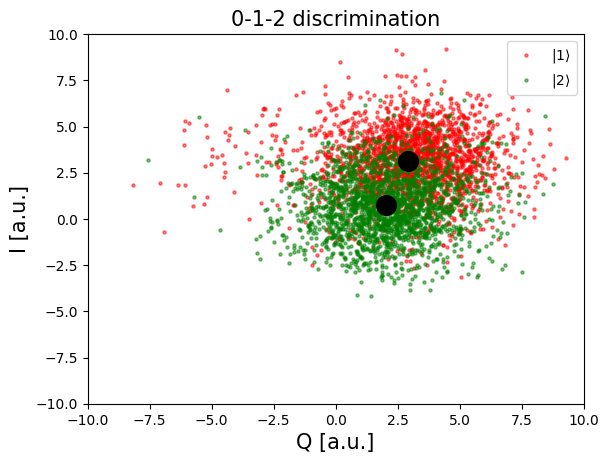

In [147]:
x_min = -10
x_max = 10
y_min = -10
y_max = 10
IQ_012_plot(x_min, x_max, y_min, y_max)

In [118]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [119]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [120]:
# Create IQ vector (split real, imag parts)
# zero_data_reshaped = reshape_complex_vec(zero_data)
# one_data_reshaped = reshape_complex_vec(one_data)  
# two_data_reshaped = reshape_complex_vec(two_data)  

# IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
# print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


In [121]:
# construct vector w/ 0's, 1's and 2's (for testing)
# state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
# state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
# state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
# # print(len(state_012))

# # Shuffle and split data into training and test sets
# IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)


In [122]:
# classifier = svm.SVC(kernel = 'rbf')
# classifier.fit(IQ_012_train, state_012_train)

SVC()

In [123]:
# print(classifier.score(IQ_012_train, state_012_train))

0.7311197916666666


In [150]:
# LDA_012 = LinearDiscriminantAnalysis()
# LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [151]:
# print(LDA_012.score(IQ_012_train, state_012_train))

0.7180989583333334


In [135]:
# qubit_classifiers.append(classifier)


We now get these same variables for qubit 1

In [49]:
target_qubit = 1

default_qubit_freq = backend_defaults.qubit_freq_est[target_qubit] # Default qubit frequency in Hz.
print(f"Qubit {target_qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[target_qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

Qubit 1 has an estimated frequency of 4.772693775386564 GHz.
Default anharmonicity is -0.3102210761952548 GHz.


In [50]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(target_qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [51]:
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)
spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(target_qubit+1, target_qubit+1)

qc_spect.x(target_qubit)
qc_spect.append(spect_gate, [target_qubit])
qc_spect.measure(target_qubit, target_qubit)
qc_spect.add_calibration(spect_gate, (target_qubit,), freq12_sweep_sched, [freq])


exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]


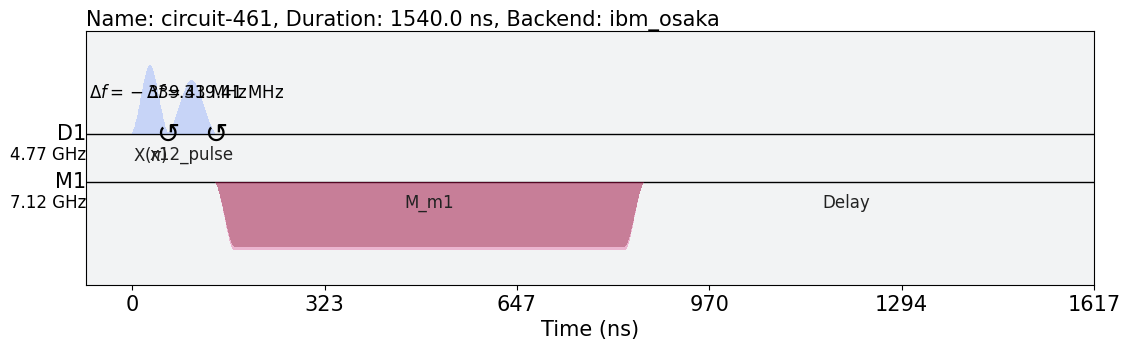

In [52]:
from qiskit import transpile, schedule
# from qiskit.pulse import Schedule, Play, ControlChannel, GaussianSquare

schedule = schedule(exp_spect_circs[1], backend)
schedule.draw(backend=backend)

In [24]:
# excited_freq_sweep_job = backend.run(exp_spect_circs,
#                                      meas_level=1,
#                                      meas_return='avg',
#                                      shots=2048)

In [55]:
excited_freq_sweep_data = get_job_data(backend.retrieve_job('crv2x9xx484g008f8zvg'), average=True, qubit = 1)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)


Our updated estimate for the 1->2 transition frequency is 4.4630365 +/- 0.00014708606830536266 GHz.


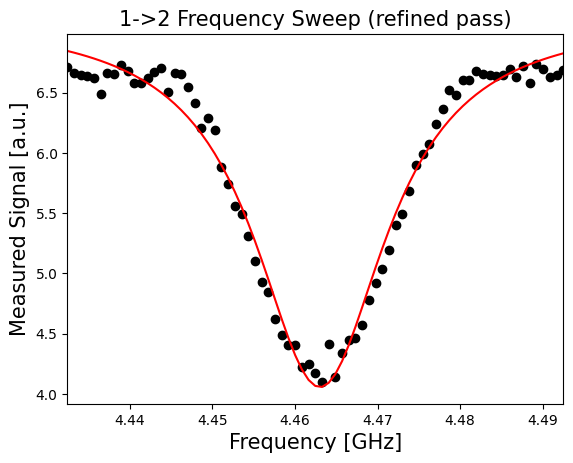

In [56]:
(excited_sweep_fit_params,
 excited_sweep_y_fit, err) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data,
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [20, 4.46*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

# Note: we are only plotting the real part of the signal
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} +/- {np.sqrt(err[1,1]/GHz**2)} GHz.")

plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [57]:
qubit_frequency_data.append(qubit_12_freq)

In [58]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(target_qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [59]:
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(2, 2)

qc_rabi.x(1)
qc_rabi.append(rabi_gate, [1])
qc_rabi.measure(1, 1)
qc_rabi.add_calibration(rabi_gate, (1,), rabi_sched, [amp])

    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]



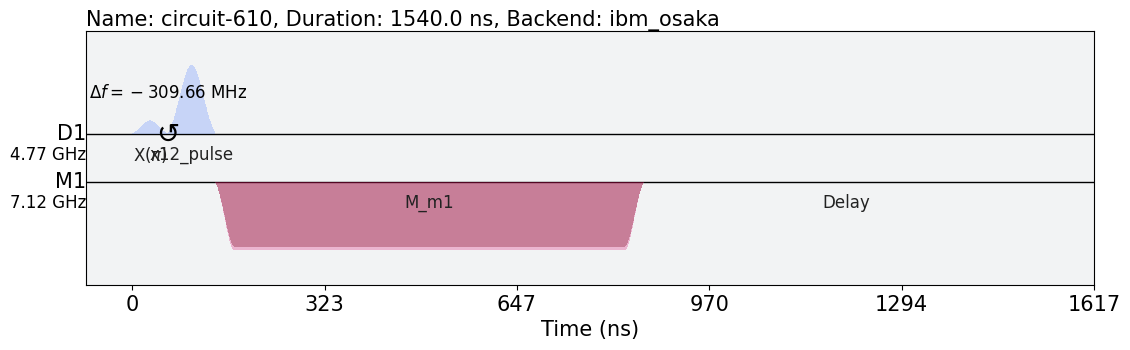

In [60]:
from qiskit import transpile, schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [61]:
# rabi_12_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=2048)

In [72]:
rabi_12_data = backend.retrieve_job('crv6fvfx484g008f9akg').result()

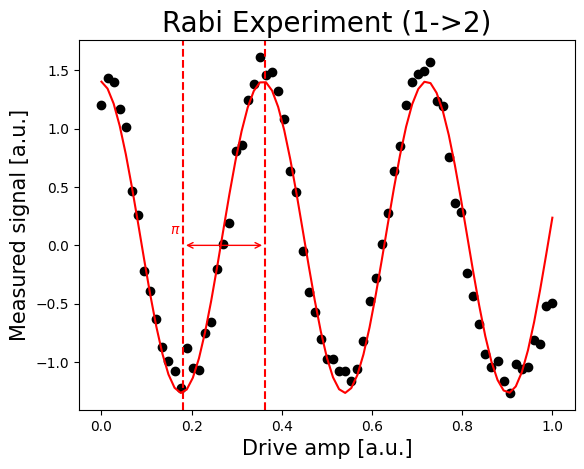

In [74]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_12_data.get_memory(i)[target_qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))
(rabi_12_fit_params, 
 rabi_12_y_fit, err) = fit_function(drive_amps,
                               rabi_values, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.75, 0, 0.4, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [75]:
print(f"Pi Amplitude (1->2) = {pi_amp_12} +/- {np.sqrt(err[2,2]/2)}")

Pi Amplitude (1->2) = 0.18127759195827067 +/- 0.0011622337974871255


In [76]:
qubit_pi_pulse_data.append(pi_amp_12)

In [77]:
print(qubit_frequency_data)
print(qubit_pi_pulse_data)

[4513040960.46839, 4463036478.657935]
[0.17233418945216408, 0.18127759195827067]


In [103]:
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(1)
    pulse.set_frequency(qubit_frequency_data[1], drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=qubit_pi_pulse_data[1],
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [104]:
# Create the three circuits

# 0 state
qc_ground = QuantumCircuit(2, 2)
qc_ground.measure(1, 1)

# 1 state
qc_one = QuantumCircuit(2, 2)
qc_one.x(1)
qc_one.measure(1, 1)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(2, 2)
qc_x12.x(1)
qc_x12.append(x12_gate, [1])
qc_x12.measure(1, 1)
qc_x12.add_calibration(x12_gate, (1,), x12_sched, [])

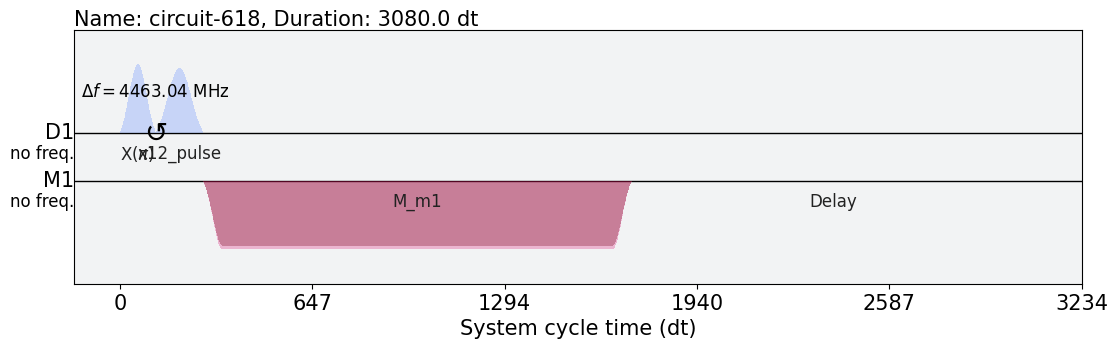

In [105]:
schedule(qc_x12, backend).draw()

In [107]:
# IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
#                           meas_level=1, 
#                           meas_return='single', 
#                           shots=1024)

In [148]:
IQ_012_data = get_job_data(backend.retrieve_job('crv7b9dx484g008f9dkg'), average=False, qubit = 1)
control_zero_data = IQ_012_data[0]
control_one_data = IQ_012_data[1]
control_two_data = IQ_012_data[2]

In [153]:
import math
def classify_control(point: complex):
    """Classify the given state as |1> or |2>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return 1 + int(distance(point, np.mean(control_two_data)) < distance(point, np.mean(control_one_data)))

/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(target_one_data), np.imag(target_one_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(target_two_data), np.imag(target_two_data),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_one), np.imag(mean_one),
/var/folders/57/15j825g52f9dkn7hff7bjbl40000gn/T/ipykernel_88082/1539969448.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_two), np.imag(mean_two),


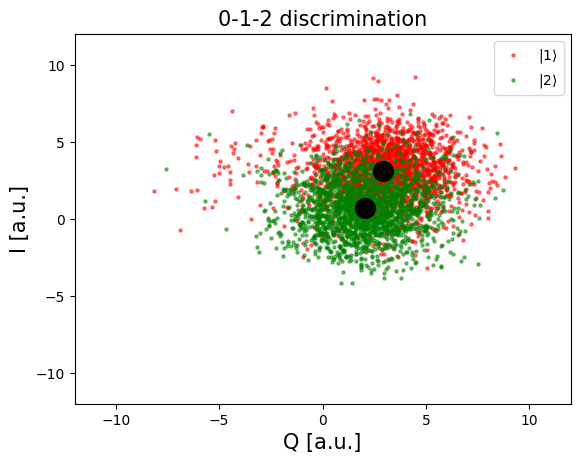

In [149]:
x_min = -12
x_max = 12
y_min = -12
y_max = 12
IQ_012_plot(x_min, x_max, y_min, y_max)

In [113]:
# zero_data_reshaped = reshape_complex_vec(zero_data)
# one_data_reshaped = reshape_complex_vec(one_data)  
# two_data_reshaped = reshape_complex_vec(two_data)  

# IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))

# state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
# state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
# state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
# # print(len(state_012))

# # Shuffle and split data into training and test sets
# IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)
# classifier = svm.SVC(kernel = 'rbf')
# classifier.fit(IQ_012_train, state_012_train)
# print(classifier.score(IQ_012_train, state_012_train))

0.80078125


In [106]:
# qubit_classifiers.append(classifier)

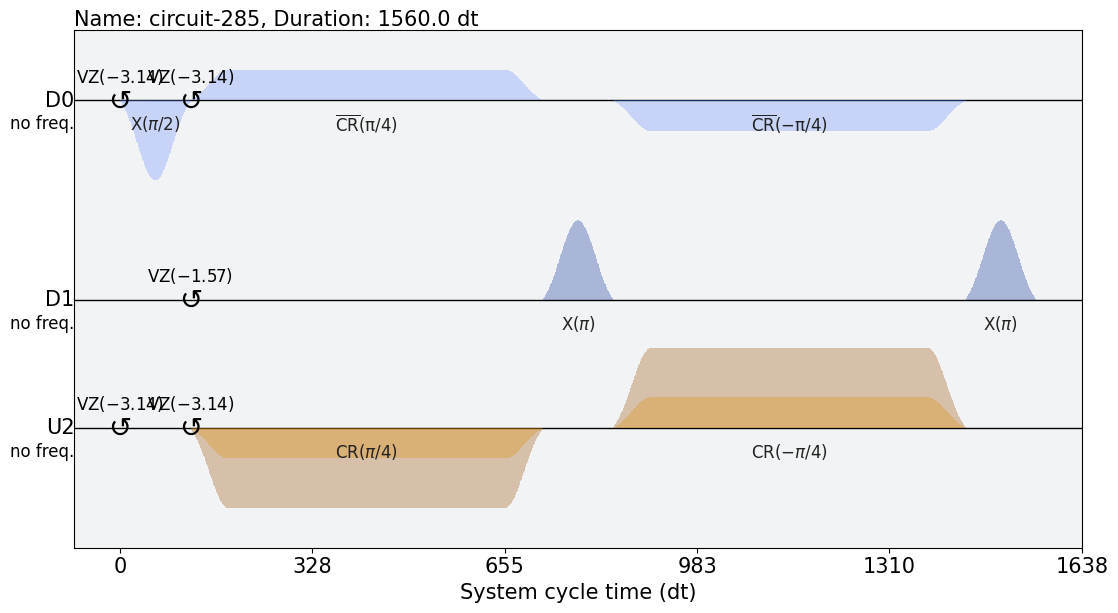

In [14]:
from qiskit import schedule
qc = QuantumCircuit(2,2)
# qc.h(0)
# qc.barrier()
qc.cx(1,0)
# qc.rxx(np.pi/4, 1, 0)

circ = transpile(qc, backend=backend)
sched = schedule(circ, backend=backend)
# print(sched)
sched.draw()

In [152]:
wave = inst_map.get('ecr', qubits = (1,0))
print(wave)


Schedule((0, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.03317685418568182, angle=0.017221932496578784, name='CR90p_d0_u2'), DriveChannel(0), name='CR90p_d0_u2')), (0, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.1296234246516003, angle=-2.9302446600528596, name='CR90p_u2'), ControlChannel(2), name='CR90p_u2')), (600, Play(Drag(duration=120, sigma=30, beta=-0.014966562421325243, amp=0.1921823506699478, angle=0.0, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), (720, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.03317685418568182, angle=-3.124370721093215, name='CR90m_d0_u2'), DriveChannel(0), name='CR90m_d0_u2')), (720, Play(GaussianSquare(duration=600, sigma=32, width=472, amp=0.1296234246516003, angle=0.2113479935369336, name='CR90m_u2'), ControlChannel(2), name='CR90m_u2')), name="ecr")


In [6]:
wave.draw()

NameError: name 'wave' is not defined

In [17]:
inst_map.get('x', qubits = [0])

Schedule((0, Play(Drag(duration=120, sigma=30, beta=-0.1971907694653226, amp=0.18765981386266964, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")